<a href="https://colab.research.google.com/github/gusibi/oneplus/blob/master/colab/text_to_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install requirement

In [ ]:
%pip install --quiet --upgrade diffusers transformers accelerate safetensors mediapy triton scipy ftfy spacy==3.4.4
# The xformers package is mandatory to be able to create several 768x768 images.
%pip install -q xformers==0.0.16rc425

# Convert lora safetensor to diffusers

In [ ]:
# Convert lora safetensor to diffusers
# https://github.com/huggingface/diffusers/blob/main/scripts/convert_lora_safetensor_to_diffusers.py
!pip install safetensors
!pip install --quiet --upgrade diffusers transformers accelerate safetensors mediapy triton scipy ftfy spacy==3.4.4
# The xformers package is mandatory to be able to create several 768x768 images.
!%pip install -q xformers==0.0.16rc425
import os


def convert(
    base_model_path, checkpoint_path, LORA_PREFIX_UNET, LORA_PREFIX_TEXT_ENCODER, alpha
):
    # base_model_path             default=None, type=str, required=True, help="Path to the base model in diffusers format."    runwayml/stable-diffusion-v1-5
    # checkpoint_path             default=None, type=str, required=True, help="Path to the checkpoint to convert." lora model path
    # LORA_PREFIX_UNET            default="lora_unet", type=str, help="The prefix of UNet weight in safetensors"
    # LORA_PREFIX_TEXT_ENCODER    default="lora_te",type=str, help="The prefix of text encoder weight in safetensors",
    # alpha                       default=0.75,  type=float, help="The merging ratio in W = W0 + alpha * deltaW")
    import torch
    from safetensors.torch import load_file
    from diffusers import StableDiffusionPipeline

    # load base model
    pipeline = StableDiffusionPipeline.from_pretrained(
        base_model_path, torch_dtype=torch.float32
    )

    # load LoRA weight from .safetensors
    state_dict = load_file(checkpoint_path)

    visited = []

    # directly update weight in diffusers model
    for key in state_dict:
        # it is suggested to print out the key, it usually will be something like below
        # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"

        # as we have set the alpha beforehand, so just skip
        if ".alpha" in key or key in visited:
            continue

        if "text" in key:
            layer_infos = (
                key.split(".")[0].split(LORA_PREFIX_TEXT_ENCODER + "_")[-1].split("_")
            )
            curr_layer = pipeline.text_encoder
        else:
            layer_infos = key.split(".")[0].split(LORA_PREFIX_UNET + "_")[-1].split("_")
            curr_layer = pipeline.unet

        # find the target layer
        temp_name = layer_infos.pop(0)
        while len(layer_infos) > -1:
            try:
                curr_layer = curr_layer.__getattr__(temp_name)
                if len(layer_infos) > 0:
                    temp_name = layer_infos.pop(0)
                elif len(layer_infos) == 0:
                    break
            except Exception:
                if len(temp_name) > 0:
                    temp_name += "_" + layer_infos.pop(0)
                else:
                    temp_name = layer_infos.pop(0)

        pair_keys = []
        if "lora_down" in key:
            pair_keys.append(key.replace("lora_down", "lora_up"))
            pair_keys.append(key)
        else:
            pair_keys.append(key)
            pair_keys.append(key.replace("lora_up", "lora_down"))

        # update weight
        if len(state_dict[pair_keys[0]].shape) == 4:
            weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
            weight_down = (
                state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
            )
            curr_layer.weight.data += alpha * torch.mm(
                weight_up, weight_down
            ).unsqueeze(2).unsqueeze(3)
        else:
            weight_up = state_dict[pair_keys[0]].to(torch.float32)
            weight_down = state_dict[pair_keys[1]].to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)

        # update visited list
        for item in pair_keys:
            visited.append(item)

    return pipeline


def convert_lora_to_diffuser(
    base_model_path,
    lora_model_path,
    dump_path,
    lora_prefix_unet="lora_unet",
    lora_prefix_text_encoder="lora_te",
    alpha=0.75,
    device="cuda",
    to_safetensors=True,
):
    # base_model_path             default=None, type=str, required=True, help="Path to the base model in diffusers format."    runwayml/stable-diffusion-v1-5
    # lora_model_path             default=None, type=str, required=True, help="Path to the checkpoint to convert." lora model path
    # dump_path"                  default=None, type=str, required=True, help="Path to the output model."
    # lora_prefix_unet             default="lora_unet", type=str, help="The prefix of UNet weight in safetensors"
    # lora_prefix_text_encoder     default="lora_te",type=str, help="The prefix of text encoder weight in safetensors",
    # alpha                       default=0.75,  type=float, help="The merging ratio in W = W0 + alpha * deltaW"
    # device                      default="cuda"  type=str, help="Device to use (e.g. cpu, cuda:0, cuda:1, etc.)"
    # to_safetensors              default=True, help="Whether to store pipeline in safetensors format or not."
    print("start convert")
    print(f"base_model_path: {base_model_path}")
    print(f"lora_model_path: {lora_model_path}")
    print(f"dump_path: {dump_path}")
    print(f"lora_prefix_unet: {lora_prefix_unet}")
    print(f"lora_prefix_text_encoder: {lora_prefix_text_encoder}")
    print(f"alpha: {alpha}")
    print(f"device: {device}")
    print(f"to_safetensors: {to_safetensors}")

    alpha = 0.75
    pipe = convert(
        base_model_path,
        lora_model_path,
        lora_prefix_unet,
        lora_prefix_text_encoder,
        alpha,
    )
    print("convert processing")
    pipe = pipe.to(device)

    to_safetensors = False
    print("saving model")
    pipe.save_pretrained(dump_path, safe_serialization=to_safetensors)
    print(f"saving model to {dump_path} success")


base_model_path = "windwhinny/chilloutmix" # @param
lora_model_path = "/content/lora/aki.safetensors" # @param
dump_path = "/content/outputs/aki" # @param

if not os.path.exists(dump_path):
    os.makedirs(dump_path)

convert_lora_to_diffuser(
    base_model_path=base_model_path,
    lora_model_path=lora_model_path,
    dump_path=dump_path,
)


# Load model

In [4]:
from diffusers import StableDiffusionPipeline
import torch
model_path = "/content/outputs/aki" # @param

pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float32)
pipe.to("cuda")


/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

# Generate image by text

  0%|          | 0/30 [00:00<?, ?it/s]


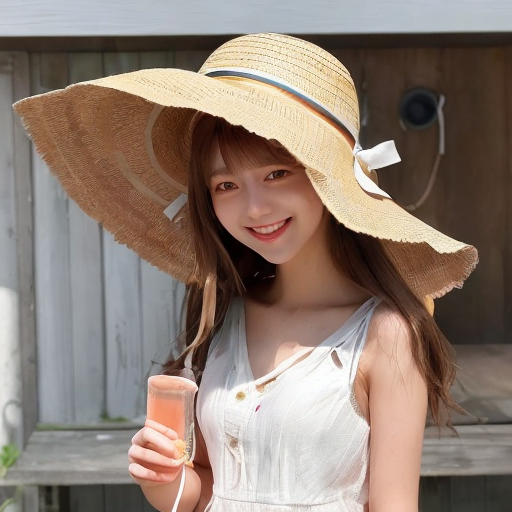

In [17]:

import mediapy as media
prompt = "1 girl, <lora:aki:0.2>, wanostyle,  smiling, straw hat, looking at viewer." # @param
height = 512 # @param
width = 512 # @param
num_inference_steps = 30 # @param
guidance_scale = 6 # @param
output_image_name = "image021.png" # @param

images = pipe(prompt, 
              height=height, 
              width=width,
              num_inference_steps=num_inference_steps, 
              guidance_scale=guidance_scale).images

media.show_images(images)
images[0].save(output_image_name)

# test code

In [ ]:
!pip install safetensors mediapy
"""
This script shows a naive way, may be not so elegant, to load Lora (safetensors) weights in to diffusers model
For the mechanism of Lora, please refer to https://github.com/cloneofsimo/lora
Copyright 2023: Haofan Wang, Qixun Wang
"""

#!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/ckpt/chilloutmix/resolve/main/chilloutmix_NiPrunedFp32Fix.safetensors -d /content/models -o chilloutmix_NiPrunedFp32Fix.safetensors

import torch
import mediapy as media
from safetensors.torch import load_file
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler

# load diffusers model
model_id = "runwayml/stable-diffusion-v1-5"
model_id = "/content/models/chilloutmix_NiPrunedFp32Fix.safetensors"
model_id = "windwhinny/chilloutmix"
pipeline = StableDiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float32)
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

# load lora weight
model_path = "/content/lora/aki.safetensors"
state_dict = load_file(model_path)

LORA_PREFIX_UNET = 'lora_unet'
LORA_PREFIX_TEXT_ENCODER = 'lora_te'

alpha = 0.75

visited = []

# directly update weight in diffusers model
for key in state_dict:
    
    # it is suggested to print out the key, it usually will be something like below
    # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"
    
    # as we have set the alpha beforehand, so just skip
    if '.alpha' in key or key in visited:
        continue
        
    if 'text' in key:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
        curr_layer = pipeline.text_encoder
    else:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
        curr_layer = pipeline.unet

    # find the target layer
    temp_name = layer_infos.pop(0)
    while len(layer_infos) > -1:
        try:
            curr_layer = curr_layer.__getattr__(temp_name)
            if len(layer_infos) > 0:
                temp_name = layer_infos.pop(0)
            elif len(layer_infos) == 0:
                break
        except Exception:
            if len(temp_name) > 0:
                temp_name += '_'+layer_infos.pop(0)
            else:
                temp_name = layer_infos.pop(0)
    
    # org_forward(x) + lora_up(lora_down(x)) * multiplier
    pair_keys = []
    if 'lora_down' in key:
        pair_keys.append(key.replace('lora_down', 'lora_up'))
        pair_keys.append(key)
    else:
        pair_keys.append(key)
        pair_keys.append(key.replace('lora_up', 'lora_down'))
    
    # update weight
    if len(state_dict[pair_keys[0]].shape) == 4:
        weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
        weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
    else:
        weight_up = state_dict[pair_keys[0]].to(torch.float32)
        weight_down = state_dict[pair_keys[1]].to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)
        
     # update visited list
    for item in pair_keys:
        visited.append(item)

pipeline = pipeline.to(torch.float16).to("cuda")
pipeline.safety_checker = lambda images, clip_input: (images, False)

prompt = '1 girl, wanostyle, monkey d luffy, smiling, straw hat, looking at viewer, solo, upper body, ((masterpiece)), (best quality), (extremely detailed), depth of field, sketch, dark intense shadows, sharp focus, soft lighting, hdr, colorful, good composition, fire all around, spectacular, <lora:aki:1>, closed shirt, anime screencap, scar under eye, ready to fight, black eyes'
negative_prompt = '(painting by bad-artist-anime:0.9), (painting by bad-artist:0.9), watermark, text, error, blurry, jpeg artifacts, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, artist name, (worst quality, low quality:1.4), bad anatomy, watermark, signature, text, logo'

with torch.no_grad():
    image = pipeline(prompt=prompt,
                     height=512, 
                     width=512,
                     num_inference_steps=50,
                     guidance_scale=8).images[0]

fileName = "./{}_{}1.png".format(prompt[:10],alpha)

# media.show_images([fileName])
image.save(fileName)

In [ ]:
from diffusers import PNDMScheduler, DDIMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler
# model_id = "stabilityai/stable-diffusion-2-1-base"
# model_id = "stabilityai/stable-diffusion-2-1"
model_id = "dreamlike-art/dreamlike-photoreal-2.0"
scheduler = None
# scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
     

In [ ]:
import mediapy as media
import torch
from diffusers import StableDiffusionPipeline

device = "cuda"

if model_id.startswith("stabilityai/"):
  model_revision = "fp16"
else:
  model_revision = None

if scheduler is None:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      torch_dtype=torch.float16,
      revision=model_revision,
      )  
else:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      scheduler=scheduler,
      torch_dtype=torch.float16,
      revision=model_revision,
      )

pipe = pipe.to(device)
pipe.enable_xformers_memory_efficient_attention()

if model_id.endswith('-base'):
  image_length = 512
else:
  image_length = 768


  0%|          | 0/25 [00:00<?, ?it/s]


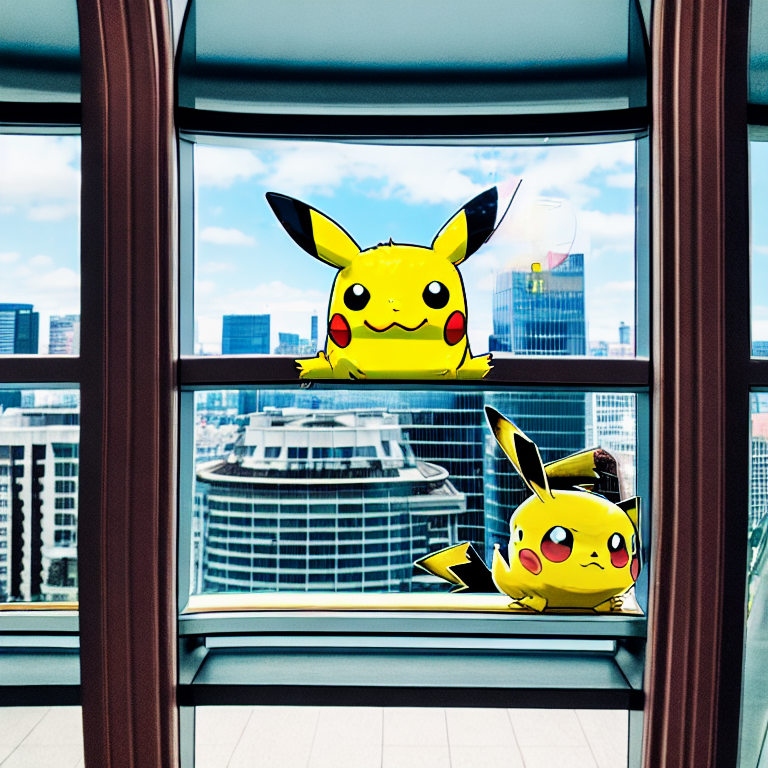
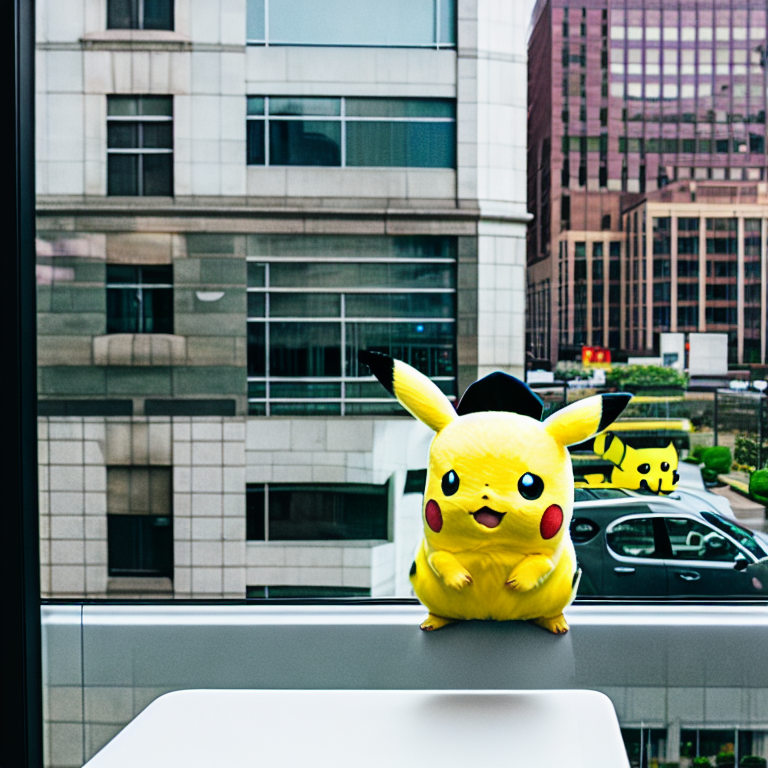
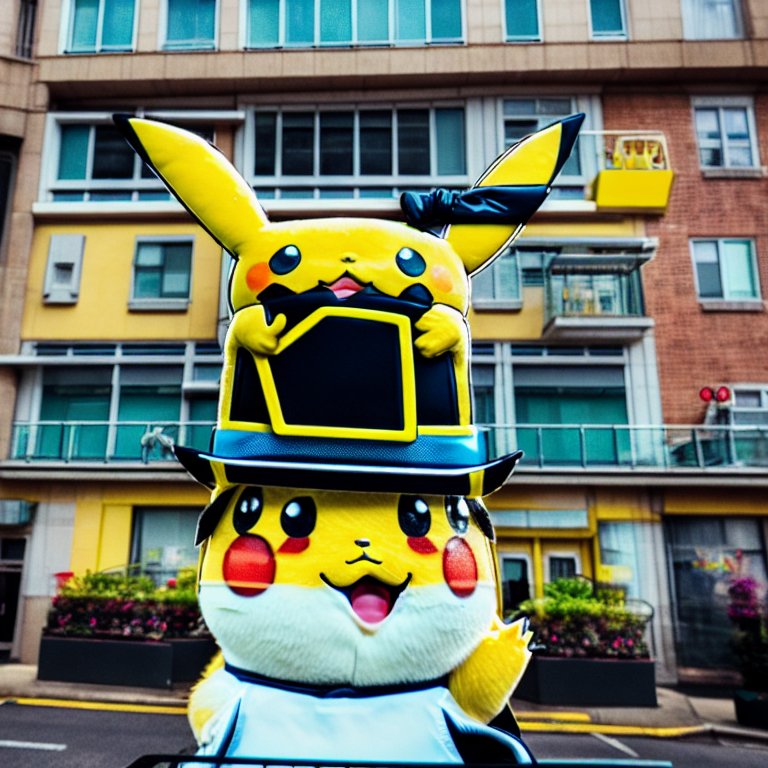
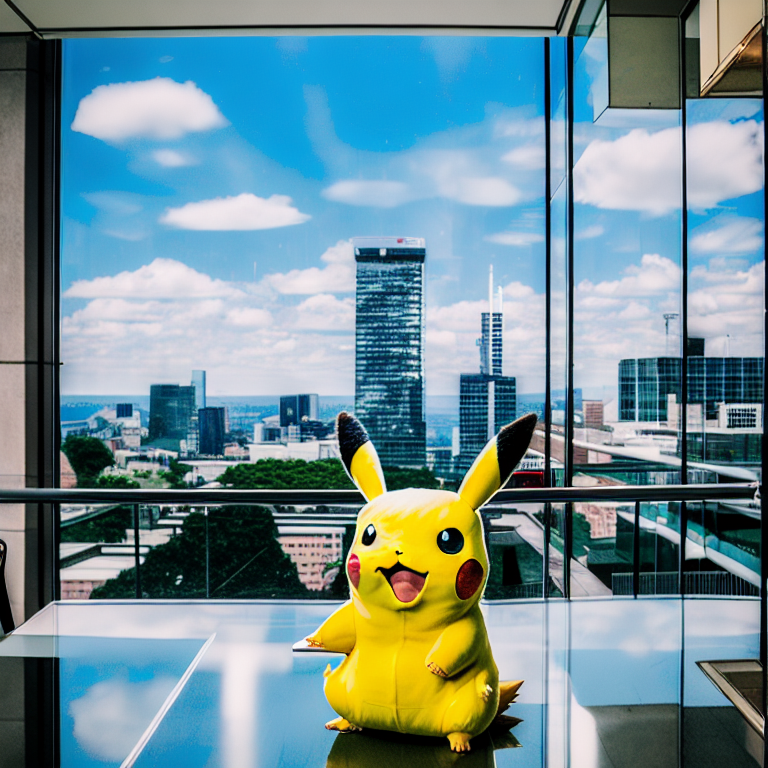

In [ ]:
prompt = "a photo of Pikachu fine dining with a view to the Eiffel Tower"
remove_safety = False
num_images = 4

if remove_safety:
  negative_prompt = None
  pipe.safety_checker = None
else:
  negative_prompt = "nude, naked"

images = pipe(
    prompt,
    height = image_length,
    width = image_length,
    num_inference_steps = 25,
    guidance_scale = 9,
    num_images_per_prompt = num_images,
    negative_prompt = negative_prompt,
    ).images
    
media.show_images(images)
images[0].save("output.jpg")